In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# import all the libraries
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

In [5]:
# Load stock data

stock_directory = '../data/price/raw'
stock_data = {}

csv_files = [file for file in os.listdir(stock_directory) if file.endswith('.csv')]
for file in csv_files:
    symbol = file.split('.')[0]  # Extract stock symbol from filename
    df = pd.read_csv(os.path.join(stock_directory, file))
    df['Date'] = pd.to_datetime(df['Date'])
    df.fillna(method='ffill', inplace=True)
    stock_data[symbol] = df

In [6]:
# import tweet data

tweet_directory = '../data/tweet/raw'
tweets_data = {}
tweet_threshold = 500   # Minimum number of tweets required for a stock to be considered

for stock_folder in os.listdir(tweet_directory):
    stock_path = os.path.join(tweet_directory, stock_folder)
    if os.path.isdir(stock_path):
        all_tweets = []
        count = 0
        for tweet_file in os.listdir(stock_path):
            count += 1
            file_path = os.path.join(stock_path, tweet_file)
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    try:
                        tweet_json = json.loads(line.strip())
                        tweet_data = {
                            'Date': pd.to_datetime(tweet_json['created_at']),
                            'Text': tweet_json['text'],
                            'User': tweet_json['user']['screen_name'],
                            'Followers': tweet_json['user']['followers_count'],
                            'Friends': tweet_json['user']['friends_count']
                        }
                        all_tweets.append(tweet_data)
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON in file {file_path}")
        # if len(all_tweets) >= tweet_threshold:
        if count >= tweet_threshold:
            tweets_data[stock_folder] = pd.DataFrame(all_tweets)

In [7]:
# Filter out stock data for which we don't have tweets
stock_data = {symbol: df for symbol, df in stock_data.items() if symbol in tweets_data}
len(stock_data)

27

In [8]:
# Convert tweet dates to date objects if not already
for stock, df in tweets_data.items():
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    tweets_data[stock] = df

In [9]:
# Group tweets by date
# This is required since we might have multiple tweets for a single date
for stock, df in tweets_data.items():
    grouped = df.groupby('Date').agg({
        'Text': list,          
        'User': list,          
        'Followers': list,     
        'Friends': list        
    }).reset_index()

    tweets_data[stock] = grouped

In [10]:
# Merge stock data with tweet data
for stock in stock_data.keys():
    if stock in tweets_data:
        
        stock_data[stock]['Date'] = pd.to_datetime(stock_data[stock]['Date'])
        tweets_data[stock]['Date'] = pd.to_datetime(tweets_data[stock]['Date'])

        merged_data = stock_data[stock].merge(tweets_data[stock], on='Date', how='left')
        
        stock_data[stock] = merged_data

In [11]:
stock_data.keys()

dict_keys(['AAPL', 'AMZN', 'BA', 'BABA', 'BAC', 'C', 'CELG', 'CSCO', 'CVX', 'D', 'DIS', 'FB', 'GE', 'GOOG', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MSFT', 'PCLN', 'PFE', 'T', 'V', 'VZ', 'WMT', 'XOM'])

Basic detail for the data. For this assignment I am providing details of one of the stock we are going to work with - Amazon

In [12]:
# Display basic information about the dataset
df = stock_data['AMZN']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   Close      1258 non-null   float64       
 5   Adj Close  1258 non-null   float64       
 6   Volume     1258 non-null   int64         
 7   Text       529 non-null    object        
 8   User       529 non-null    object        
 9   Followers  529 non-null    object        
 10  Friends    529 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 108.2+ KB
None


In [13]:
# Get the shape of the dataset (rows, columns)
print("Dataset size:", df.shape)

Dataset size: (1258, 11)


In [14]:
# Get descriptive statistics of the numerical columns
print(df.describe())

                                Date         Open         High          Low  \
count                           1258  1258.000000  1258.000000  1258.000000   
mean   2015-03-06 06:26:53.990460928   501.609142   506.091534   496.507846   
min              2012-09-04 00:00:00   221.309998   225.160004   218.179993   
25%              2013-12-04 06:00:00   306.372498   310.299995   303.010010   
50%              2015-03-07 12:00:00   389.669998   392.395004   384.445007   
75%              2016-06-05 06:00:00   713.882507   718.850006   709.467484   
max              2017-09-01 00:00:00  1069.550049  1083.310059  1043.199951   
std                              NaN   234.667207   235.711427   233.071006   

             Close    Adj Close        Volume  
count  1258.000000  1258.000000  1.258000e+03  
mean    501.530740   501.530740  3.698896e+06  
min     220.600006   220.600006  9.844000e+05  
25%     306.547508   306.547508  2.510575e+06  
50%     388.399994   388.399994  3.136150e+06  


In [15]:
# Check for missing values
print(df.isnull().sum())

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
Text         729
User         729
Followers    729
Friends      729
dtype: int64


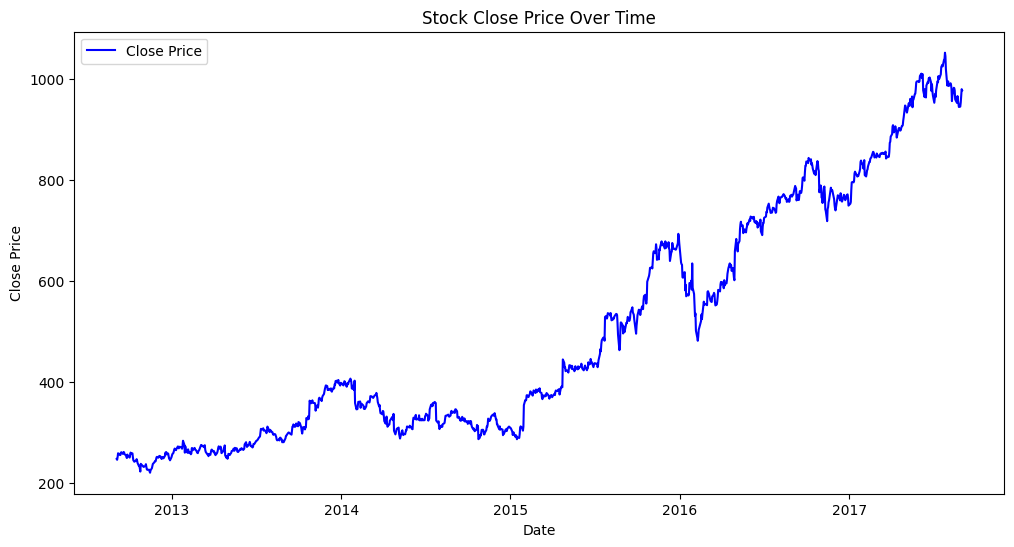

In [17]:
# Time series analysis of stock data
# Plot the stock prices over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()